<a href="https://colab.research.google.com/github/ManvithaKola/Fashion-Recommendation-System/blob/main/Personalized_Fashion_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps needed build Fashion Collection:
1.   Convert images to embeddings
2.   Conduct Transfer Learning from ResNet
3.   Use Fastai hooks to retrieve image embeddings from step 2
4.   Use Approximate Nearest Neighbors and embeddings centroid detection to obtain most similar images based on the embeddings from step 3.

Results: Given any image, we can generate recommendations for it instantly.




# Initial Setup

In [ ]:
# #reference: 
# #https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903

# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy
!pip install gdown

     |████████████████████████████████| 655kB 7.9MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391575 sha256=c9fa7c87e0cfb472ed0e909a75a2a3b5c8b1a518c0ca841d1e0d0af31527fa7e
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline


In [ ]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Tue Mar 23 17:52:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

## Get DeepFashion Data

DeepFashion data set: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html


In [ ]:
# get the images
'''
import zipfile
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/AA_Recommender/'
zip_ref = zipfile.ZipFile("gdrive/My Drive/Colab Notebooks/AA_Recommender/img.zip", 'r')
zip_ref.extractall(root_path)
zip_ref.close()
'''


Mounted at /content/gdrive


OSError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/AA_Recommender/'
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('gdrive/My Drive/Colab Notebooks/AA_Recommender/list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('gdrive/My Drive/Colab Notebooks/AA_Recommender/list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('gdrive/My Drive/Colab Notebooks/AA_Recommender/list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

Mounted at /content/gdrive


In [ ]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_label'])
data_df['category_label'] = data_df['category_label'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_label'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_label', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [ ]:
len(data_df)

289222

In [ ]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [ ]:
len(data_df.category.unique())

46

In [ ]:
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


# Convert images to embeddings

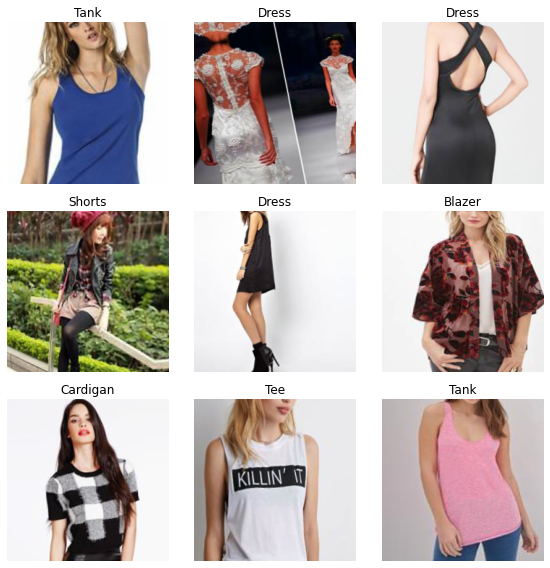

In [ ]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from ResNet

## Resnet18/50

In [ ]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier, model I used

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [ ]:
#learner.fit_one_cycle(10, max_lr=1e-02)

## Evaluate Model 

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

NameError: ignored

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet-fashion')

In [ ]:
# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner.save('resnet-fashion')
# learner.save('/content/gdrive/My Drive/resnet50-fashion')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


NameError: ignored

In [ ]:
# view model details
learner.model.module

# Use Fastai hooks to retrieve image embeddings

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
drive.mount('/content/gdrive') 


model_path = "resnet-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# Save your features as an numpy array

np.save('gdrive/My Drive/Colab Notebooks/AA_Recommender/saved_features.npy', saved_features)

In [ ]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

ValueError: ignored

# Use Approximate Nearest Neighbors to obtain most similar images

In [ ]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 


# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return data_df_ouput.iloc[similar_img_ids[1:]] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [ ]:
# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

## Embeddings Centroid Detection

In [ ]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

In [ ]:
# image explorer 
img_index = np.random.randint(len(data_df_ouput),size=1)[0]
print(img_index)
open_image(data_df_ouput.iloc[109938, 0])

### Anything with shorts

In [ ]:
# shorts
outfit_img_ids = [109938, 106385, 113703, 98666, 113467, 120667, 20840, 8450, 142843, 238607, 124505,222671]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

In [ ]:
show_similar_images(outfits_selected, fig_size=[15,15])

In [ ]:
show_similar_images(similar_images_df, fig_size=[20,20])

### Urban Lifestyle

In [ ]:
# urban 

outfit_img_ids = [50374, 226654, 60186, 56384, 46254, 212771, 118639, 33918, 228773, 46332, 118173, 146836]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

In [ ]:
show_similar_images(outfits_selected, fig_size=[15,15])

In [ ]:
show_similar_images(similar_images_df, fig_size=[20,20])

### Flowery Dreams

In [ ]:
# flower theme

outfit_img_ids = [171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

In [ ]:
show_similar_images(outfits_selected, fig_size=[15,15])

In [ ]:
show_similar_images(similar_images_df, fig_size=[20,20])